In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from PIL import Image

In [2]:
# Định nghĩa các tham số
IMG_SIZE = (128,128)
dataset_path = "cat-and-dog"  
train_path = os.path.join(dataset_path, "training_set/training_set")
test_path = os.path.join(dataset_path, "test_set/test_set")

In [3]:
# Hàm resize ảnh
def resize_image(image_path, size=IMG_SIZE):
    img = Image.open(image_path).resize(size)
    return img

In [4]:
# Hàm chuyển ảnh sang grayscale
def convert_to_grayscale(img):
    return rgb2gray(np.array(img))

In [5]:
# Hàm trích xuất HOG
def extract_hog_features(gray_img):
    hog_features, hog_img = hog(
        gray_img, visualize=True, block_norm='L2-Hys', pixels_per_cell=(8, 8), cells_per_block=(3, 3)
    )
    return hog_features, hog_img

In [6]:
def visualize_image_processing():
    category = np.random.choice(["cats", "dogs"])
    folder = os.path.join(train_path, category)
    files = os.listdir(folder)
    img_path = os.path.join(folder, np.random.choice(files))

    # Resize ảnh
    resized_img = resize_image(img_path)
    # Chuyển về grayscale
    gray_img = convert_to_grayscale(resized_img)
    # Trích xuất HOG
    _, hog_img = extract_hog_features(gray_img)

    # Hiển thị ảnh qua các bước xử lý
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.imshow(resized_img)
    plt.title("Ảnh Resize")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(gray_img, cmap='gray')
    plt.title("Ảnh Grayscale")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(hog_img, cmap='gray')
    plt.title("Ảnh HOG")
    plt.axis("off")

    plt.show()

In [7]:
def extract_features_and_labels(path):
    features, labels = [], []
    for label, category in enumerate(["cats", "dogs"]):
        category_path = os.path.join(path, category)
        if not os.path.exists(category_path):
            print(f"Lỗi: Thư mục {category_path} không tồn tại!")
            continue
        for file in os.listdir(category_path):
            img_path = os.path.join(category_path, file)
            try:
                resized_img = resize_image(img_path)
                gray_img = convert_to_grayscale(resized_img)
                hog_features, _ = extract_hog_features(gray_img)
                features.append(hog_features)
                labels.append(label)
            except Exception as e:
                print(f"Lỗi xử lý ảnh {img_path}: {e}")
                continue
    return np.array(features), np.array(labels)


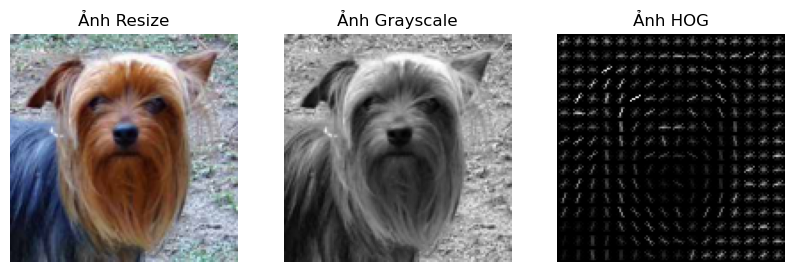

In [8]:
visualize_image_processing()

In [9]:
# Load dữ liệu
X_train, y_train = extract_features_and_labels(train_path)
X_test, y_test = extract_features_and_labels(test_path)
print(f" Dữ liệu train: {X_train.shape}, Dữ liệu test: {X_test.shape}")

✅ Dữ liệu train: (8005, 15876), Dữ liệu test: (2023, 15876)


In [10]:
# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
# Giảm chiều bằng PCA
pca = PCA(n_components=50)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

In [12]:
# Tìm tham số tối ưu với GridSearchCV
svm = SVC(kernel='rbf', probability=True)
param_grid = {'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]}
grid_search = GridSearchCV(svm, param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=SVC(probability=True),
             param_grid={'C': [0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1]})

In [13]:
# Train mô hình với tham số tốt nhất
best_svm = grid_search.best_estimator_
best_svm.fit(X_train, y_train)

SVC(C=10, gamma=0.001, probability=True)

In [14]:
def test_random_image():
    category = np.random.choice(["cats", "dogs"])
    test_folder = os.path.join(test_path, category)
    files = os.listdir(test_folder)

    if not files:
        print(" Không tìm thấy ảnh test!")
        return
    
    image_file = np.random.choice(files)
    img_path = os.path.join(test_folder, image_file)

    # Xử lý ảnh
    resized_img = resize_image(img_path)
    gray_img = convert_to_grayscale(resized_img)
    hog_features, hog_img = extract_hog_features(gray_img)
    hog_features = scaler.transform([hog_features])
    hog_features = pca.transform(hog_features)

    # Dự đoán
    prediction = best_svm.predict(hog_features)    
    label_map = {0: "Cat", 1: "Dog"}
    plt.imshow(Image.open(img_path))
    plt.title(f"Predicted: {label_map[prediction[0]]} | Actual: {category.capitalize()}")
    plt.axis('off')
    plt.show()

 Dự đoán trên ảnh test ngẫu nhiên:


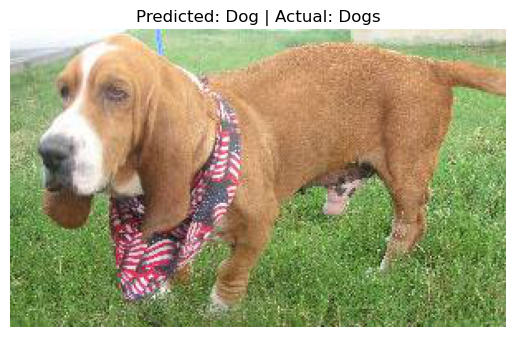

In [15]:
print(" Dự đoán trên ảnh test ngẫu nhiên:")
test_random_image()

In [16]:
# Dự đoán và đánh giá
y_pred = best_svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f" Độ chính xác mô hình: {accuracy:.4f}")
print(classification_report(y_test, y_pred, target_names=["Cat", "Dog"]))

🎯 Độ chính xác mô hình: 0.7726
              precision    recall  f1-score   support

         Cat       0.75      0.82      0.78      1011
         Dog       0.80      0.72      0.76      1012

    accuracy                           0.77      2023
   macro avg       0.78      0.77      0.77      2023
weighted avg       0.78      0.77      0.77      2023



In [17]:
#Ma trận nhầm lẫn
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[834 177]
 [283 729]]
